### Problem Statement

<b>Context</b>
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

<b>Objective</b>
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to compute distances
from scipy.spatial.distance import pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

<IPython.core.display.Javascript object>

In [2]:
# Lets read the credit card customer data
cccdf = pd.read_excel("F:/d4mlp/Credit Card Customer Data.xlsx")

<IPython.core.display.Javascript object>

<b>Data Description</b>
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

<b>Data Dictionary</b>

1. Sl_No: Primary key of the records
2. Customer Key: Customer identification number
3. Average Credit Limit: Average credit limit of each customer for all credit cards
4. Total credit cards: Total number of credit cards possessed by the customer
5. Total visits bank: Total number of visits that customer made (yearly) personally to the bank
6. Total visits online: Total number of visits or online logins made by the customer (yearly)
7. Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

In [3]:
# Lets look at the data with columns for their data types
cccdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

In [4]:
# Looks like the data has no null values and most of them are numeric/could be categorical data,
cccdf.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


<IPython.core.display.Javascript object>

In [5]:
# We shall look at the describe output
cccdf.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


<IPython.core.display.Javascript object>

In [6]:
# Columns like Sl_No and Customer Key have not much meaning/value of a Customer Characteristics and they are mere identifiers and could be dropped

# Before dropping, lets make a copy and work on the Copy
data = cccdf.copy()

data = data.drop(["Sl_No", "Customer Key"], axis=1)

<IPython.core.display.Javascript object>

### Univariate Analysis

In [7]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="cyan"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="mako"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

In [8]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

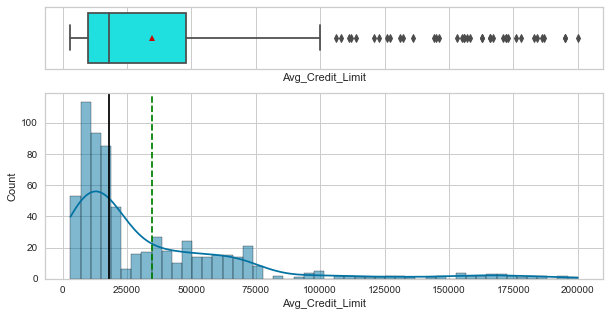

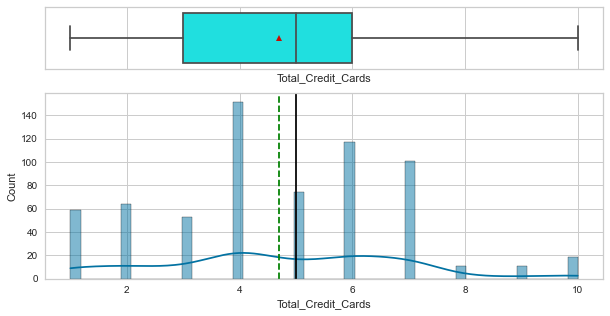

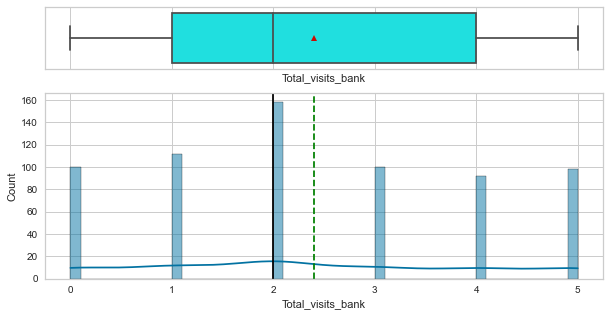

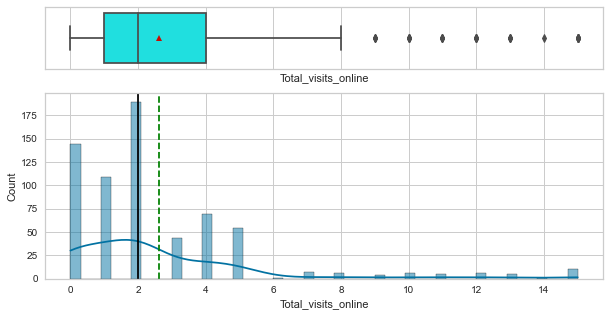

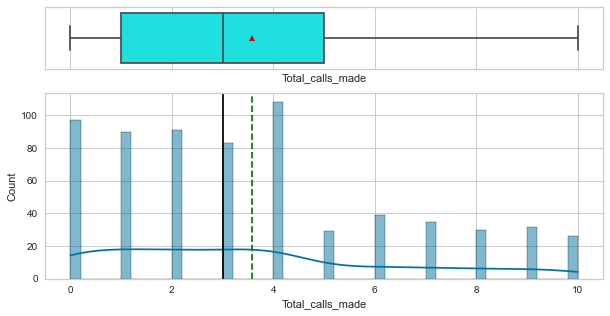

<IPython.core.display.Javascript object>

In [9]:
# we can look at the histogram box plot for all columns as all columns are numeric types
all_cols = data.columns

for item in all_cols:
    histogram_boxplot(data, item, bins=50, kde=True, figsize=(10, 5))

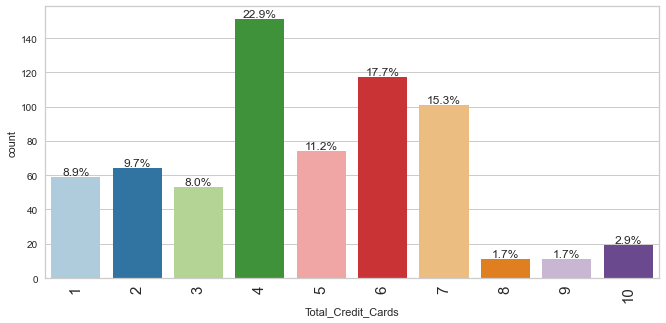

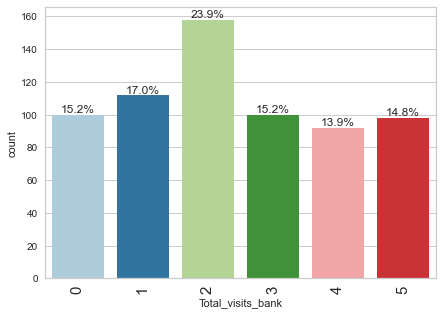

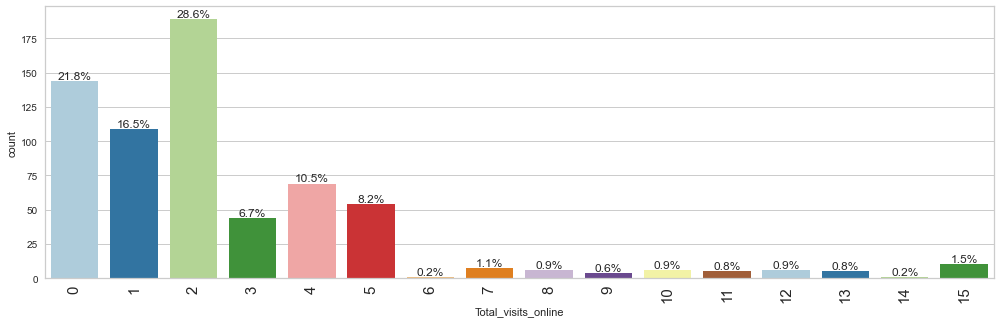

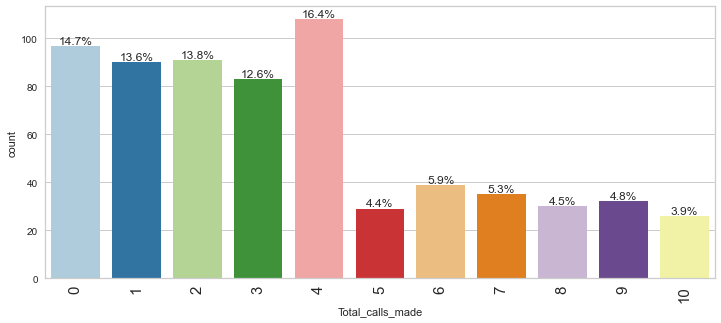

<IPython.core.display.Javascript object>

In [10]:
# we can look at the histogram box plot for all columns as all columns are numeric types
count_cols = [
    "Total_Credit_Cards",
    "Total_visits_bank",
    "Total_visits_online",
    "Total_calls_made",
]

for item in count_cols:
    labeled_barplot(data, item, perc=True)

### Inferences from Univariate Analysis
1. Median Avg Credit Limit is 18K, the mean at 34K, while the maximum is 200K, which indicates a large number of outliers in Credit Limits
2. 75% of the Customers have atleast 4 Credit Cards, with the mean at 4+
3. 70% of the Customers visit the Bank more than twice per year, with the mean at 2+
4. 80% of the Customers are online atleast once or more per year, with the mean at 2+
5. 70% of the Customers make atleast 1 or more calls to the bank per year, with the mean at 3+

### Bivariate Analysis

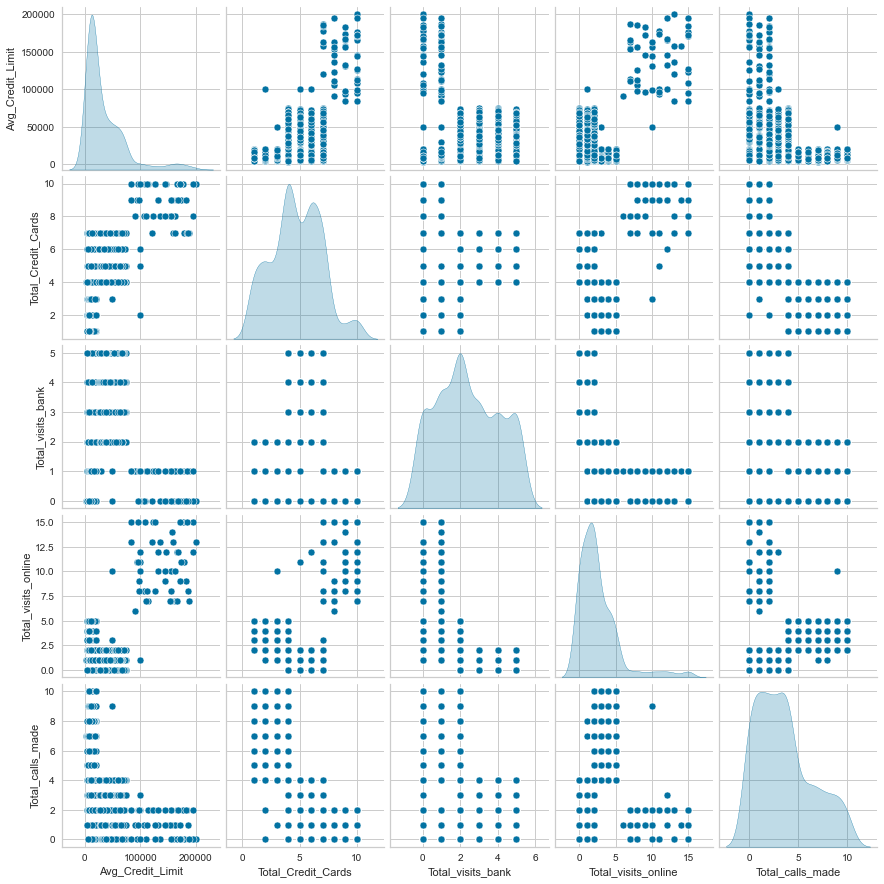

<IPython.core.display.Javascript object>

In [11]:
sns.pairplot(data=data[all_cols], diag_kind="kde")

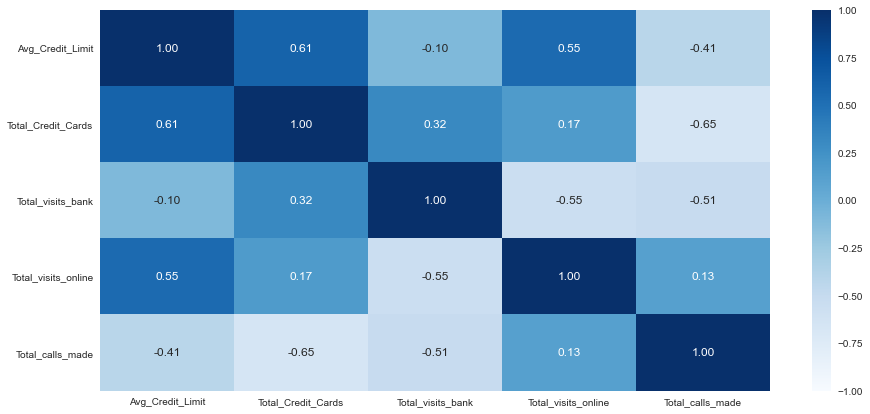

<IPython.core.display.Javascript object>

In [12]:
plt.figure(figsize=(15, 7))
sns.heatmap(data[all_cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Blues")
plt.show()

### Observations

1. Total_Credit_Cards is strongly correlated with Avg_Credit_Limit, and is as expected
2. Total_visits_bank is slightly negatively correlated with Avg_Credit_Limit
3. Total_visits_online is showing postive correlation against Avg_Credit_Limit
5. There is no strong correlation between the various variables

### EDA Insights

1. The Average Credit Limit shows a good number of data points outside of the 3rd Inter Quantile Range, above 100K and shows a linear correlation with number Credit Cards
2. 75% of the Customers have atleast 4 Credit Cards, with the mean at 4+, and they show postive correlation with total visits to the bank, total calls made and total times online
3. 70% of the Customers visit the Bank more than twice per year, with the mean at 2+
4. 80% of the Customers are online atleast once or more per year, with the mean at 2+
5. 70% of the Customers make atleast 1 or more calls to the bank per year, with the mean at 3+

### Data preprocessing


In [13]:
# Lets Check if we have any missing values, We do not have any records which are null or is missing

data.isnull().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

In [14]:
# Lets look for Duplicates in the data
mySeries = data.duplicated(subset=data.columns)
counter = 0

for ind in mySeries:
    if ind == True:
        counter = counter + 1

        # print(data.iloc[[counter-1]])
print("Number of Duplicates =", counter)

# There are 11 Records which are duplicates out of 660 Records, we could leave these duplicates as it is

Number of Duplicates = 11


<IPython.core.display.Javascript object>

In [15]:
# Lets Apply the StandardScaler to scale the data as part of Outlier treatment
sc = StandardScaler()

scaled_data = sc.fit_transform(data)

dataScaled = pd.DataFrame(scaled_data, columns=data.columns)
dataScaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


<IPython.core.display.Javascript object>

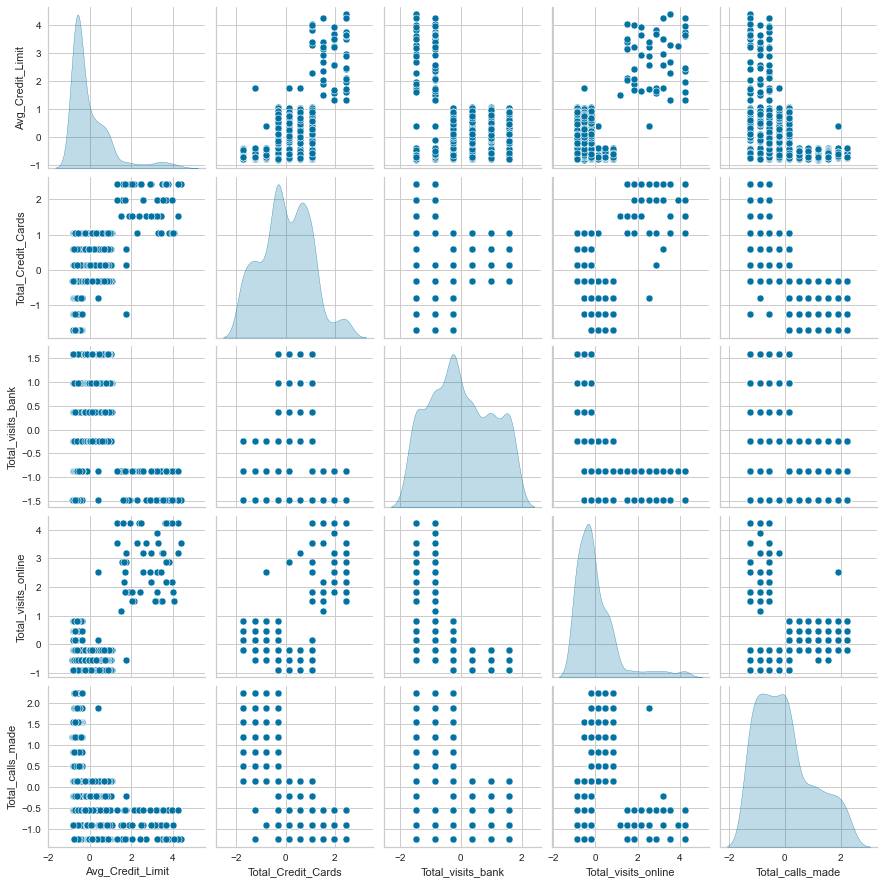

<IPython.core.display.Javascript object>

In [16]:
sns.pairplot(dataScaled, diag_kind="kde")

In [17]:
### CDF Plot of numerical variables

<IPython.core.display.Javascript object>

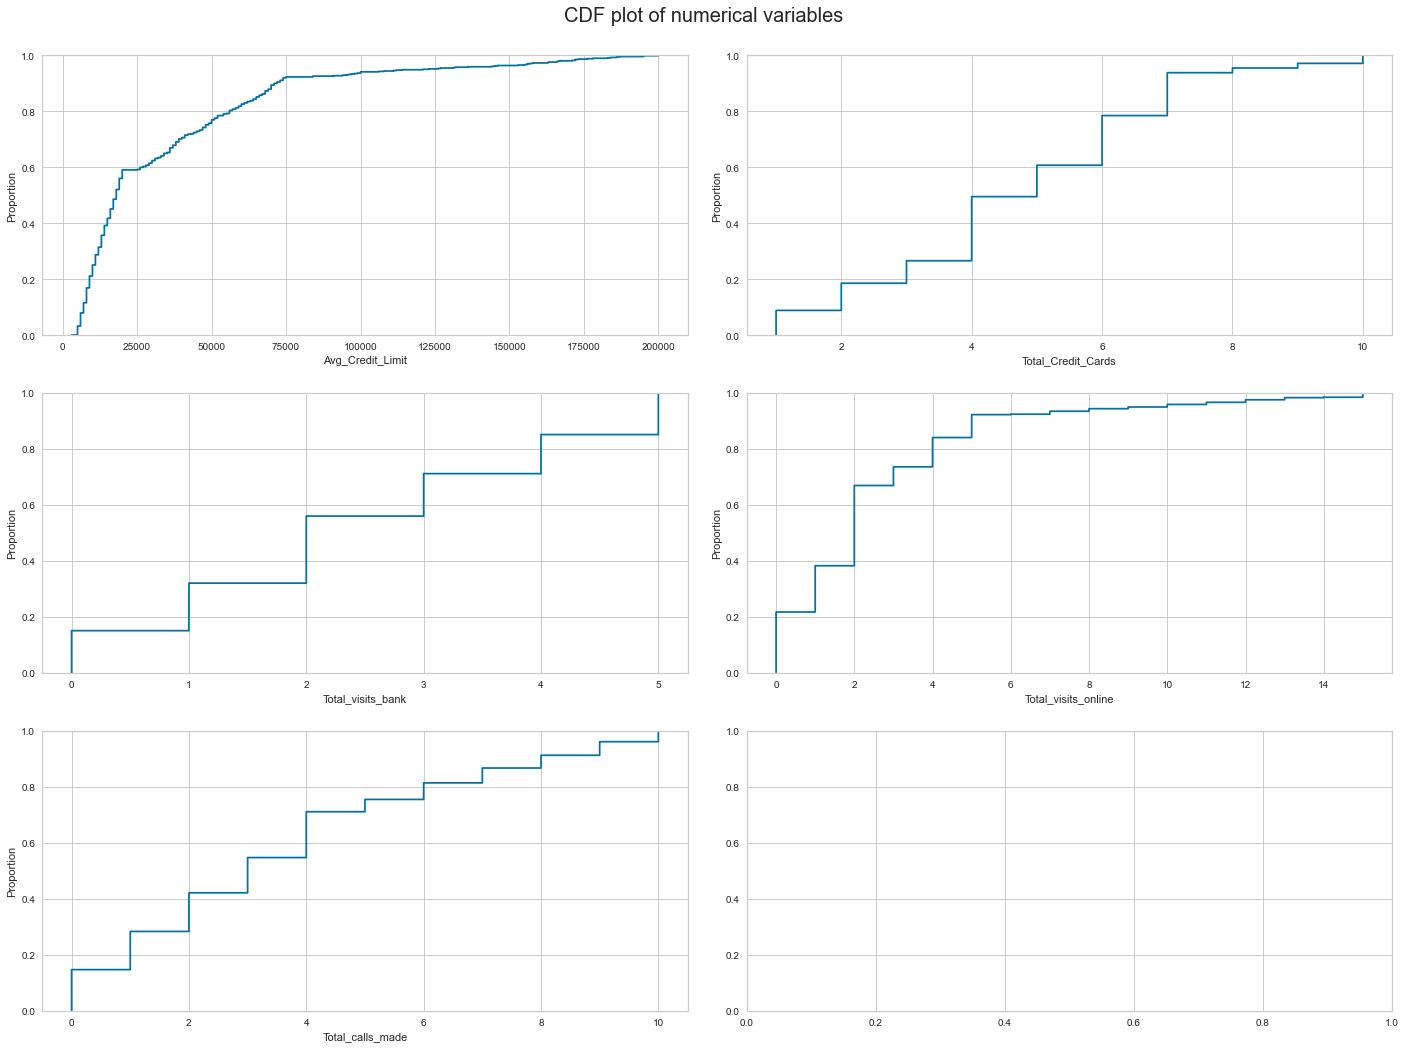

<IPython.core.display.Javascript object>

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=data[all_cols[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=data[all_cols[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

**Observations**

- 90% of the Avg_Credit_Limit is less than 75000.
- 80% of the Customers have 2 or more credit cards.
- 80% of the Customers have atleast 1 Total_visits_bank per year.
- 80% of the Customers have atleast 1 Total_visits_online per year.
- 80% of the Customers have atleast 1 Total_calls_made per year.

### K-means Clustering

Now, we will use K-Means clustering to group data based on their attribute. First, we need to determine the optimal number of groups. For that we conduct the knee test to see where the knee happens.

C:\Users\lakshminarayanan.r\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.990772333470802
Number of Clusters: 6 	Average Distortion: 0.9429882588535909
Number of Clusters: 7 	Average Distortion: 0.9095137283638062
Number of Clusters: 8 	Average Distortion: 0.8904067093983766


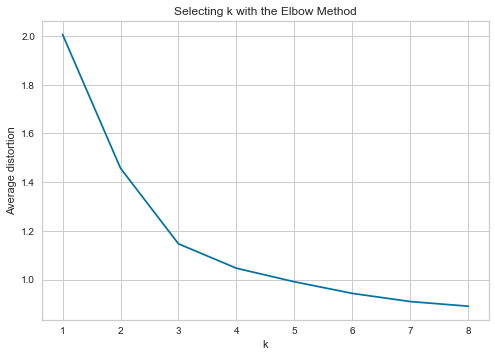

<IPython.core.display.Javascript object>

In [19]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(dataScaled)
    prediction = model.predict(dataScaled)
    distortion = (
        sum(
            np.min(cdist(dataScaled, model.cluster_centers_, "euclidean"), axis=1)
        )
        / dataScaled.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()



For n_clusters = 2, the silhouette score is 0.41842496663215445)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3556670619372605)
For n_clusters = 5, the silhouette score is 0.2726898791817692)
For n_clusters = 6, the silhouette score is 0.25545029453623114)
For n_clusters = 7, the silhouette score is 0.24892566568541563)
For n_clusters = 8, the silhouette score is 0.22702114062830683)
For n_clusters = 9, the silhouette score is 0.2175391141428743)


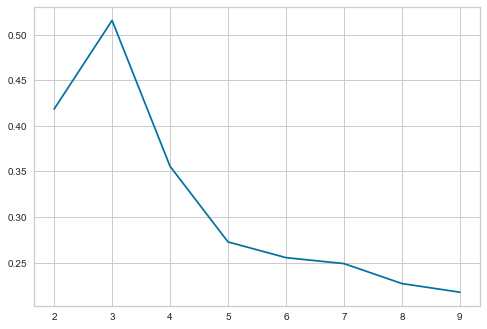

<IPython.core.display.Javascript object>

In [20]:
### Let's check the Silhouette Scores

sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((dataScaled))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(dataScaled, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

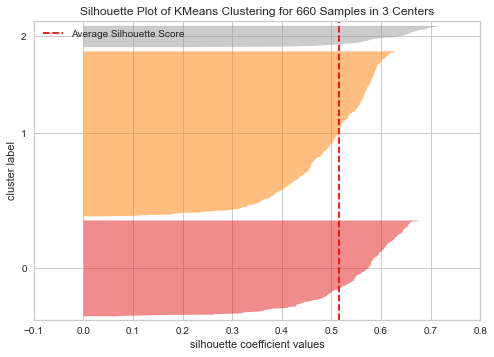

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [21]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(dataScaled)
visualizer.show()

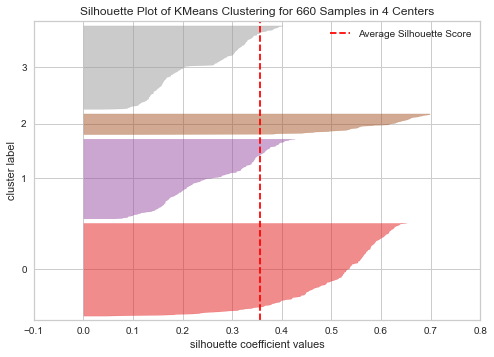

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [22]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(dataScaled)
visualizer.show()

### Inferences on K Means

1. The value of K, as signified by n_clusters = 3, produces the best Silhouette score of 0.515718255888106
2. The same inference is confirmed by the Elbow method, which shows place of decline of distortion(steepest is from 1 to 3)
3. We could use the 3 Clusters and do Cluster Grouping. Will study the Cluster Profile later when we complete agglomerative clustering

In [23]:
# Let us first start with K = 5
final_model = KMeans(3)
final_model.fit(dataScaled)
prediction = final_model.predict(dataScaled)

# Append the prediction
data["K_MEANS_CLUSTER"] = prediction
dataScaled["K_MEANS_CLUSTER"] = prediction
print("K_MEANS_CLUSTER Assigned : \n")
dataScaled.head()

K_MEANS_CLUSTER Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_MEANS_CLUSTER
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,1
2,0.410293,1.058973,-0.860451,0.134290,0.145528,0
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,2


<IPython.core.display.Javascript object>

### Hierarchical Clustering

In [24]:
hdata = cccdf.copy()
hdata = hdata.drop(["Sl_No", "Customer Key"], axis=1)

<IPython.core.display.Javascript object>

In [25]:
hdata.columns

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')

<IPython.core.display.Javascript object>

In [26]:
# Lets Apply the StandardScaler to scale the data
sch = StandardScaler()

hdata_scaled = sch.fit_transform(hdata)

hdataScaled = pd.DataFrame(hdata_scaled, columns=hdata.columns)
hdataScaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


<IPython.core.display.Javascript object>

In [27]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(hdataScaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(hdataScaled))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875361.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

<IPython.core.display.Javascript object>

In [28]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

In [29]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(hdataScaled, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(hdataScaled))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


<IPython.core.display.Javascript object>

In [30]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


<IPython.core.display.Javascript object>

### Inference from Linkage & Cophenetic Correlation

* Cophenetic correlation is 0.8977080867389372, which is also the highest is achieved with Euclidean distance & Centroid linkage
* Plotting the Dendograms, we could establish the number of clusters with Agglomerative Clustering

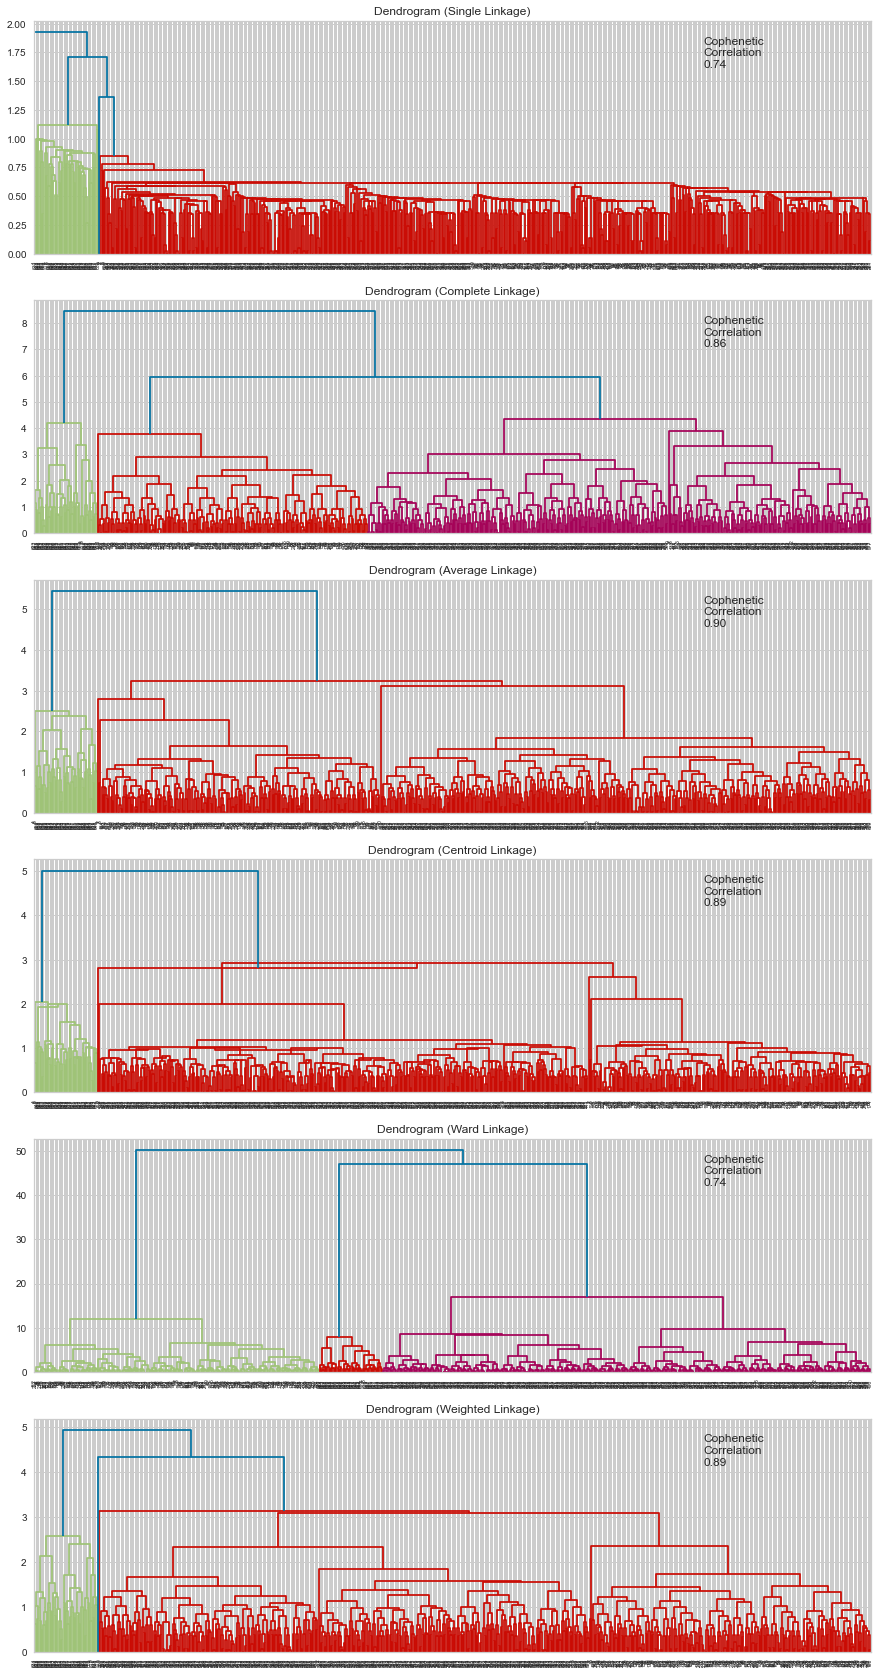

<IPython.core.display.Javascript object>

In [31]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hdataScaled, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(hdataScaled))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

In [32]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(hdataScaled)

AgglomerativeClustering(linkage='average', n_clusters=3)

<IPython.core.display.Javascript object>

In [33]:
hdataScaled["HC_Clusters"] = HCmodel.labels_
hdata["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

### Cluster Profiling

In [34]:
cluster_profile_km_mean = data.groupby("K_MEANS_CLUSTER").mean()

<IPython.core.display.Javascript object>

In [35]:
cluster_profile_km_mean["count_per_cluster"] = (
    data.groupby("K_MEANS_CLUSTER")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [36]:
cluster_profile_km_mean.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_per_cluster
K_MEANS_CLUSTER,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

In [37]:
cluster_profile_km_med = data.groupby("K_MEANS_CLUSTER").median()

<IPython.core.display.Javascript object>

In [38]:
cluster_profile_km_med["count_per_cluster"] = (
    data.groupby("K_MEANS_CLUSTER")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [39]:
cluster_profile_km_med.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_per_cluster
K_MEANS_CLUSTER,,,,,,
0,31000,6,3,1,2,386
1,12000,2,1,4,7,224
2,145500,9,1,11,1,50


<IPython.core.display.Javascript object>

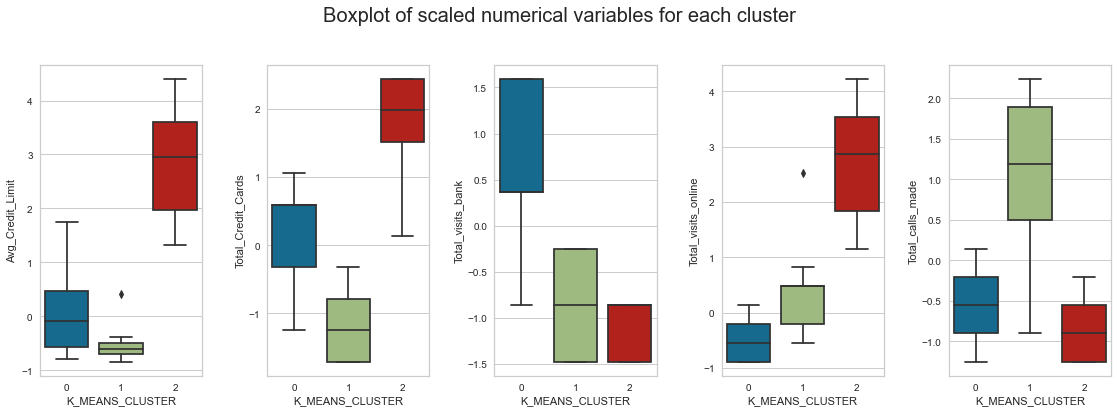

<IPython.core.display.Javascript object>

In [40]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=dataScaled[all_cols[counter]], x=dataScaled["K_MEANS_CLUSTER"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

# Inference on Customer Clusters

<b>Cluster-0</b>
*  This is the Core group of Customers with average Credit Limit of 33K per year based on their Credit Limit
*  Customers in this cluster have 5 or more credit cards with their median at 6 and mean at 5.5
*  Customers in this cluster atleast 3 or more visits to the bank, which indicates that they could have less issues with the bank or they are comfortable making in person issue resolution
*  This Cluster has the maximum number of customers at 386
*  These Customers could be less educated or they are less digitally Savvy, as they have very less online presence
*  These Customers are also comfortable resolving their issues through phone calls, if they are not visiting the bank


<b>Cluster-1</b>
*  This is the Core group of Customers with average Credit Limit of 12K per year based on their Credit Limit
*  Customers in this cluster have 2 credit cards as their median at 2 and mean at 2.4
*  Customers in this cluster on an average visit the bank only once per year or lesser
*  This Cluster have around 224 Customers and form the second largest group
*  These Customers could be educated and are more digitally Savvy, they are online on an average of 3.5 times per year
*  These Customers have a high average of 7 phone calls per year



<b>Cluster-2</b>

*  This is the Core group of Customers with average Credit Limit of 141K per year based on their Credit Limit
*  Customers in this cluster have 8.74 credit cards as their median at 9 as mean
*  Customers in this cluster on an average visit the bank not even once per year or lesser
*  This Cluster have around 50 Customers and are the smallest group
*  These Customers could be educated and are most digitally Savvy, they are online on an average of 10.9 times per year
*  These Customers have an average of 1 phone calls per year, and could be having less complaints



In [41]:
cluster_profile = hdata.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [42]:
cluster_profile["count_per_cluster"] = (
    hdata.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [43]:
# lets display cluster profile
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_per_cluster
HC_Clusters,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


<IPython.core.display.Javascript object>

In [44]:
print(hdataScaled.columns)

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made', 'HC_Clusters'],
      dtype='object')


<IPython.core.display.Javascript object>

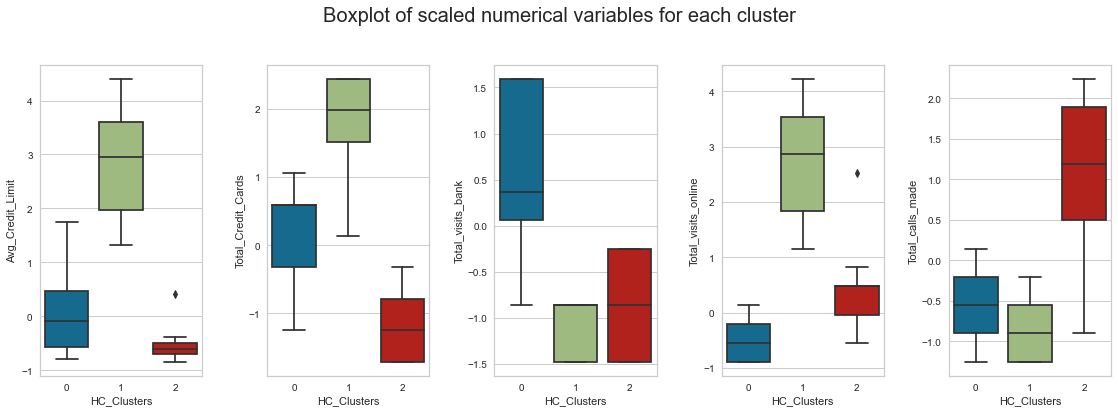

<IPython.core.display.Javascript object>

In [45]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=hdataScaled[all_cols[counter]], x=hdataScaled["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

# Inference on Customer Clusters based on hierarchical clustering are almost similar to kMeans

<b>Cluster-0</b>
*  This is the Core group of Customers with average Credit Limit of 33K per year based on their Credit Limit
*  Customers in this cluster have 5 or more credit cards with their median at 6 and mean at 5.5
*  Customers in this cluster atleast 3 or more visits to the bank, which indicates that they could have less issues with the bank or they are comfortable making in person issue resolution
*  This Cluster has the maximum number of customers at 387
*  These Customers could be less educated or they are less digitally Savvy, as they have very less online presence
*  These Customers are also comfortable resolving their issues through phone calls, if they are not visiting the bank


<b>Cluster-1</b>
*  This is the Core group of Customers with average Credit Limit of 12K per year based on their Credit Limit
*  Customers in this cluster have 2 credit cards as their median at 2 and mean at 2.4
*  Customers in this cluster on an average visit the bank only once per year or lesser
*  This Cluster have around 223 Customers and form the second largest group
*  These Customers could be educated and are more digitally Savvy, they are online on an average of 3.5 times per year
*  These Customers have a high average of 7 phone calls per year



<b>Cluster-2</b>

*  This is the Core group of Customers with average Credit Limit of 141K per year based on their Credit Limit
*  Customers in this cluster have 8.74 credit cards as their median at 9 as mean
*  Customers in this cluster on an average visit the bank not even once per year or lesser
*  This Cluster have around 50 Customers and are the smallest group
*  These Customers could be educated and are most digitally Savvy, they are online on an average of 10.9 times per year
*  These Customers have an average of 1 phone calls per year, and could be having less complaints



### Inferred Business Insights

1. Cluster-2 could be the customers with good credit scores, higher average credit limit(141K), 9+ credit cards and lower number of complaints or issues
2. Cluster-1 could be the customers with least credit scores, lower average credit limit(12K) and have 2+ credit cards maximum complaints due to higher number of calls
3. Cluster-0 could be the customers with average credit scores, average credit limt(33K) , and have 5+ credit cards and with minimum complaints


### Recommendations

<b>The Bank should provide more transparent digital channels of communication like text messages, periodic communication with customers in Cluster-0 & Cluster-1 to ensure that they have less reasons to make a phone call or visit the bank</b>